In [ ]:
!pip install pdf2image opencv-python pytesseract pillow numpy

In [ ]:
!apt-get update && apt-get install -y poppler-utils

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://cli.github.com/packages stable InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,825 kB]
Get:13 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Pa

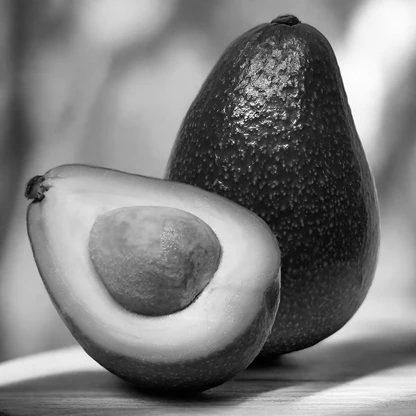

In [ ]:
# thresholding
import cv2
from google.colab.patches import cv2_imshow
image = cv2.imread("/content/avo.jpg", 0)
cv2_imshow(image)

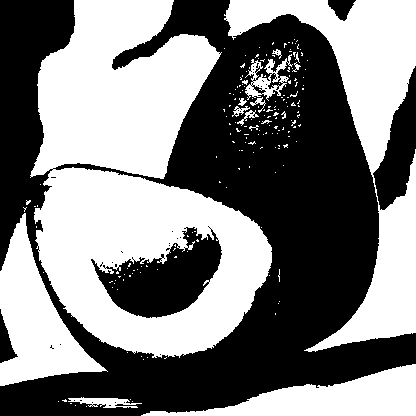

In [ ]:
# thresholding
th, res = cv2.threshold(image,130,255, cv2.THRESH_BINARY)
cv2_imshow(res)

# optimal threshold value: 130.0

In [ ]:
import cv2
import numpy as np
from PIL.PpmImagePlugin import PpmImageFile # used as type hint

# A function to preprocess our image
def preprocess_image(img: PpmImageFile) -> np.ndarray:
    gray = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_LINEAR) # Up-sizing for better extraction results
    processed_image = cv2.adaptiveThreshold(
        resized, # our resized image
        255, # max pixel value
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, # adaptive thresholding
        # cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        65,
        13
    )
    return processed_image

# Preprocess the image
# preprocess_image("/content/avo.jpg") # This line is commented out as it's not used in display_and_extract

In [ ]:
import pytesseract

# Set the path to the Tesseract executable (if not in PATH)
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

# Extract text from the image
text = pytesseract.image_to_string("processed_page_1.jpg")
print(text)

In [ ]:
import re

# Example OCR text
ocr_text = """
Dr John Smith, M.D
2 Non-Important Street,
New York, Phone (000)-111-2222
Name: Marta Sharapova Date: 5/11/2022
Address: 9 tennis court, new Russia, DC
Prednisone 20 mg
Lialda 2.4 gram
Directions:
Prednisone, Taper 5 mg every 3 days,
Finish in 2.5 weeks
Lialda - take 2 pill everyday for 1 month
Refill: 2 times
"""

# Extract patient name
name_pattern = r"Name:(.*)Date"
name = re.findall(name_pattern, ocr_text)[0].strip()
print(f"Patient Name: {name}")

# Extract address
address_pattern = r"Address:(.*)\n"
address = re.findall(address_pattern, ocr_text)[0].strip()
print(f"Address: {address}")

# Extract medicines
medicines_pattern = r"Address:[^\n]*(.*)Directions"
medicines = re.findall(medicines_pattern, ocr_text, flags=re.DOTALL)[0].strip()
print(f"Medicines: {medicines}")

In [ ]:
# A function to display before and after images and return extracted text
import matplotlib.pyplot as plt
POPPLER_PATH = r"/usr/bin" # Corrected path to the directory containing poppler binaries

def display_and_extract(path: str) -> str:
    pages_1 = convert_from_path(path, poppler_path=POPPLER_PATH)
    img = preprocess_image(pages_1[0])

    # Display images
    plt.figure(figsize=(14,10))
    plt.subplot(1, 2, 1)
    plt.imshow(pages_1[0])
    plt.axis(False)
    plt.title("Image converted from PDF")
    plt.subplot(1, 2, 2)
    plt.imshow(img, cmap="gray")
    plt.axis()
    plt.title("Preprocessed image")
    plt.show()
    print("-------------------------------------------------------------------")
    # return extracted text
    return pytesseract.image_to_string(img, lang="eng")

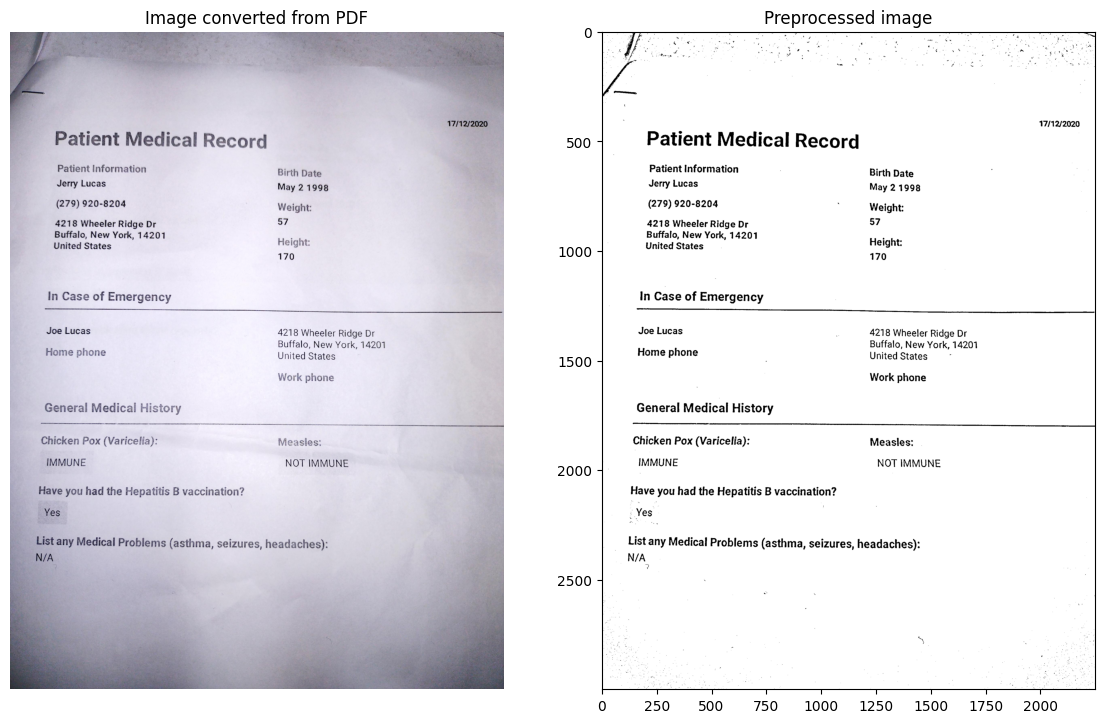

-------------------------------------------------------------------
<class 'str'>


In [ ]:
# Let's try extracting text from our patient_details_doc_1
DOC_1_PATH = "/content/pd_2.pdf"

print(type(display_and_extract(DOC_1_PATH)))

In [ ]:
!apt-get update && apt-get install -y poppler-utils

In [ ]:
from pdf2image import convert_from_path
import cv2
import numpy as np
import pytesseract
import re
from PIL import Image
from PIL.PpmImagePlugin import PpmImageFile # used as type hint


# Set path
TESSERACT_PATH = r"/usr/bin/tesseract"
POPPLER_PATH = r"/usr/bin/"

# Set Tesseract path
pytesseract.pytesseract.tesseract_cmd = TESSERACT_PATH

def pdf_to_images(pdf_path):
    """Convert PDF to images."""
    return convert_from_path(pdf_path, poppler_path=POPPLER_PATH)

def preprocess_image(img: PpmImageFile) -> np.ndarray:
    gray = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY) # Color image -> Grayscale image
    resized = cv2.resize(gray, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_LINEAR) # Up-sizing for better extraction results
    processed_image = cv2.adaptiveThreshold(
        resized, # our resized image
        255, # max pixel value
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, # adaptive thresholding
        # cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY, # converting to binary (only black/white)
        65, # block size (after trial and error)
        13  # constant (after trial and error)
    )
    return processed_image

def extract_text(img_processed: np.ndarray) -> str:
    """Extract text from image using Tesseract."""
    return pytesseract.image_to_string(img_processed, lang="eng")

def parse_text(text: str) -> dict:
    """Parse text to extract fields."""
    fields = {}

    name_match = re.search(r"Patient Information Birth Date\s*\n([A-Za-z]+ [A-Za-z]+)",
    text
    )
    if name_match:
      fields['name'] = name_match.group(1).strip()


    # Birth date: Extract the date after the name on the same line
    birth_date_match = re.search(r"Patient Information Birth Date\n.*?(\w+\s+\d{1,2}\s+\d{4})", text)
    if birth_date_match:
        fields["birth_date"] = birth_date_match.group(1).strip()
    else:
        fields["birth_date"] = None


    # Phone number: Extract the number within parentheses
    phone_match = re.search(r"\(\d{3}\)\s*\d{3}-\d{4}", text)
    if phone_match:
        fields["phone_number"] = phone_match.group(0).strip()
    else:
        fields["phone_number"] = None


    address_pattern = r"\d+.*\n.*\d{5}"
    match = re.search(address_pattern, text)
    if match:
      fields["address"] = match.group().strip()
    else:
        fields["patient_address"] = None

    # Date: Extract the first date in the format DD/MM/YYYY at the beginning of the text
    date_match = re.search(r"^(\d{2}/\d{2}/\d{4})", text, re.MULTILINE)
    if date_match:
        fields["date"] = date_match.group().strip()
    else:
        fields["date"] = None


    return fields


def main(pdf_path):
    """Main function to process PDF and extract data."""
    # Convert PDF to images
    images = pdf_to_images(pdf_path)

    # Process first page
    if images:
        image = images[0]
        processed_image = preprocess_image(image)

        # Extract text
        text = extract_text(processed_image)
        print("--- Extracted Text ---")
        print(text)
        print("----------------------")

        # Parse text
        fields = parse_text(text)

        return fields
    else:
        return {}

# Example usage
if __name__ == "__main__":
    pdf_path = "/content/pd_2.pdf" # Changed to pd_1.pdf to test the fix
    extracted_data = main(pdf_path)
    print(extracted_data)

--- Extracted Text ---
 

17/12/2020

Patient Medical Record

Patient Information Birth Date
Jerry Lucas May 2 1998
(279) 920-8204 Weight:
4218 Wheeler Ridge Dr 57

oot on 14201 Height

In Case of Emergency
eee

Joe Lucas 4218 Wheeler Ridge Dr
Buffalo, New York, 14201
Home phone United States
Work phone

General Medical History

 

Chicken Pox (Varicelia): Measles:

IMMUNE NOT IMMUNE
Have you had the Hepatitis B vaccination?
Yes |

List any Medical Problems (asthma, seizures, headaches):
N/A

----------------------
{'name': 'Jerry Lucas', 'birth_date': 'May 2 1998', 'phone_number': '(279) 920-8204', 'address': '4218 Wheeler Ridge Dr\nBuffalo, New York, 14201', 'date': '17/12/2020'}
